# Image Filtering: Spatial Methods

In [1]:
%load_ext cython

In [2]:
%matplotlib inline

import numpy as np

import matplotlib.image as img
import matplotlib.pyplot as plt

from skimage import io
from skimage.filters import sobel
from skimage.exposure import rescale_intensity
from skimage.util import img_as_float32 as img_as_float

from scipy.ndimage import convolve

In [3]:
def print_imginfo(I):
    print(type(I))
    print(I.shape, I.dtype)
    print('Data range:', np.min(I), 'to', np.max(I))

In [4]:
def show_images(I, titles=None):
    fig, ax = plt.subplots(1, len(I), figsize=(12,12))
    
    for i in np.arange(0,len(I)):
        ax[i].imshow(I[i], cmap='gray')
        ax[i].set_axis_off()
        if titles != None:
            ax[i].set_title(titles[i])

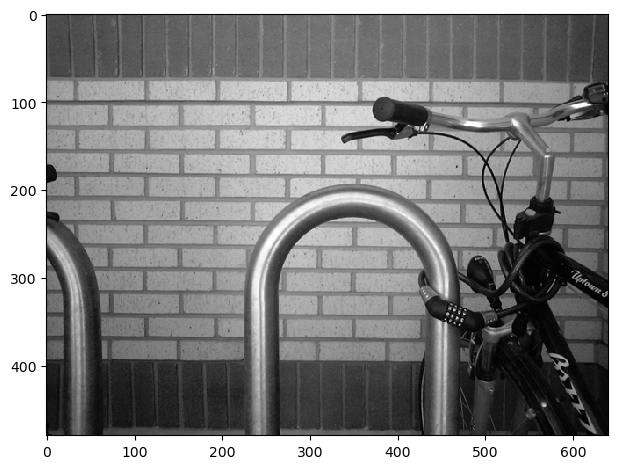

In [5]:
#I1 = io.imread("../../images/blobs.png", as_gray=True)
I1 = io.imread("../../images/bikes.jpg", as_gray=True)
I1 = img_as_float(I1)

io.imshow(I1)

## Linear Filter: Smoothing Kernels

In [6]:
def gaussian_kernel(sigma=1.0, truncate=3.0):
    K = np.int32(np.ceil(truncate*sigma))
    
    u, v = np.mgrid[-K:K+1,-K:K+1]
    
    h = np.exp(-0.5*(u**2+v**2)/(sigma**2))
    h /= h.sum()

    return h

## Linear Filter: Derivative Kernels

In [7]:
def sobel_kernel():
    h = np.array([ [1+1j,2+0j,1-1j], [0+2j,0+0j,0-2j], [-1+1j,-2+0j,-1-1j] ])
    return h/4  # normalize smoothing component of kernel: sum([1 2 1])

## Canny: Edge Thinning and Hysteresis

In [8]:
%%cython 
import numpy as np

# Quantize into four gradient angles
# Note: np.angle(x,y) = atan2(y,x)
#       angle range [-180,180] deg
#
# Q0:   0 deg:  (x+1,y),   (x-1,y)
# Q1:  45 deg:  (x+1,y+1), (x-1,y-1)
# Q2:  90 deg:  (x,y+1),   (x,y-1)
# Q3: 135 deg:  (x+1,y-1), (x-1,y+1)

cpdef angle_quantization(Ga):
    Q = np.around(((Ga+180)%180)/45)
    return Q%4

# Apply non-max gradient suppression

cpdef edge_thinning(Gm, Qa):
    Qm = np.copy(Gm)
    Gz = np.pad(Gm, ((1,1),(1,1)), mode='constant', constant_values=0)
    
    cdef int u, v
    cdef float Muv, M1, M2
    
    for u in np.arange(0,Gm.shape[0]):
        for v in np.arange(0,Gm.shape[1]):
            Muv = Gm[u][v]
            
            if Qa[u][v] == 0:
                M1 = Gz[u+0][v+1]
                M2 = Gz[u+2][v+1]
                   
            elif Qa[u][v] == 1:
                M1 = Gz[u+2][v+2]
                M2 = Gz[u+0][v+0]
                     
            elif Qa[u][v] == 2:
                M1 = Gz[u+1][v+2]
                M2 = Gz[u+1][v+0]
                
            elif Qa[u][v] == 3:
                M1 = Gz[u+2][v+0]
                M2 = Gz[u+0][v+2]
                
            if Muv < M1 or Muv < M2:
                Qm[u][v] = 0.0
                
    return Qm

cpdef edge_tracing(int u0, int v0, E, Qm, float low):
    cdef int u1, u2, u
    cdef int v1, v2, v
 
    u1 = u0 if u0 == 0 else u0-1
    u2 = u0 if u0 == E.shape[0]-1 else u0+1
    v1 = v0 if v0 == 0 else v0-1
    v2 = v0 if v0 == E.shape[1]-1 else v0+1
    
    E[u0][v0] = Qm[u0][v0]
    
    for u in np.arange(u1,u2+1):
        for v in np.arange(v1,v2+1):
            if E[u][v] == 0.0 and Qm[u][v] >= low:
                edge_tracing(u, v, E, Qm, low)
                return
    return
    
cpdef edge_hysteresis(Qm, float low=0.10, float high=0.20, threshold=True):
    E = np.zeros_like(Qm)
    
    cdef int u, v
    
    for u in np.arange(0,Qm.shape[0]):
        for v in np.arange(0,Qm.shape[1]):            
            if E[u][v] == 0.0 and Qm[u][v] >= high:
                edge_tracing(u, v, E, Qm, low)
    
    if threshold:
        E = np.where(0<E, 1.0, 0.0)
        
    return E

## Canny: Edge Detection

<class 'numpy.ndarray'>
(480, 640) float32
Data range: 0.0 to 1.0


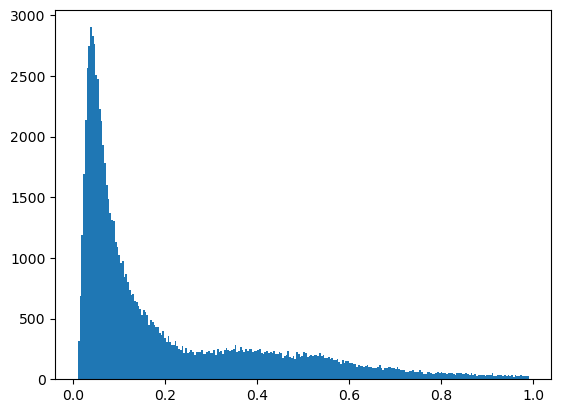

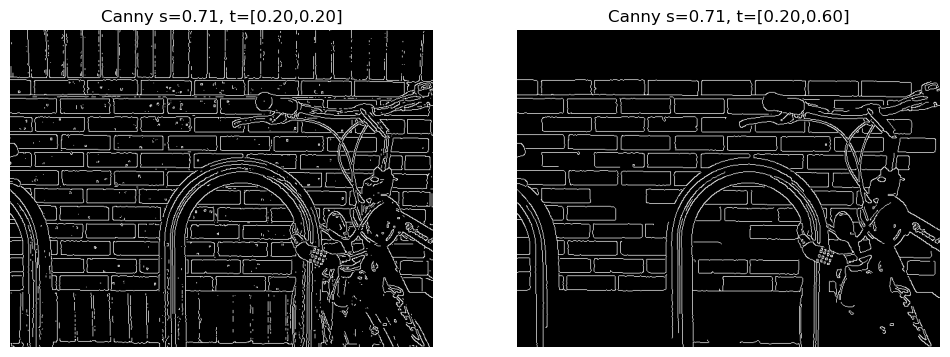

In [10]:
sigma_values = [0.5, 1/np.sqrt(2), 1.0, np.sqrt(2), 2.0, 3.0]
sigma = sigma_values[1]

low = 0.20
high = [low, 0.60]

h1 = gaussian_kernel(sigma=sigma, truncate=3)
I2 = convolve(I1, h1, mode='reflect')

h2 = sobel_kernel()
I2 = convolve(I2, h2, mode='reflect')

Gm = np.abs(I2)

#print_imginfo(Gm)
#plt.hist(Gm.ravel(),bins=256, range=(0.01,0.49))

Ga = np.angle(I2, deg=True)
Qa = angle_quantization(Ga)

Qm = edge_thinning(Gm, Qa)
Qm = rescale_intensity(Qm, in_range=(0,0.30), out_range='dtype')

print_imginfo(Qm)
plt.hist(Qm.ravel(),bins=256, range=(0.01,0.99))

C1 = edge_hysteresis(Qm, low=low, high=high[0], threshold=True)
C2 = edge_hysteresis(Qm, low=low, high=high[1], threshold=True)


T1 = 'Canny s=%.2f, t=[%.2f,%.2f]' % (sigma, low, high[0])
T2 = 'Canny s=%.2f, t=[%.2f,%.2f]' % (sigma, low, high[1])

show_images([C1, C2],[T1, T2])